# Predict global zone1-2-3

### Import modules

In [1]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2

import utils as u
import models as m

import os
import numpy as np
import pandas as pd
import xarray as xr
import scipy.ndimage

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

u.check_memory()

Using TensorFlow backend.
/home/lalandmi/.conda/envs/keras-gpu/lib/python3.6/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
/home/lalandmi/.conda/envs/keras-gpu/lib/python3.6/site-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


Memory usage: 5.6%


### Import data

In [2]:
total = xr.open_dataarray('data/ORCA025.L75-OCCITENS.e001_y1979-01-03.5d_sla.nc').load()
forced = xr.open_dataarray('data/ORCA025.L75-OCCITENS.emean_y1979-01-03.5d_sla.nc').load()
u.check_memory()

Memory usage: 5.6%


### Import model

In [3]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"  # specify which GPU(s) to be used (see GPU notebook)
# os.environ["CUDA_VISIBLE_DEVICES"]="0,1,2,3"

model = m.unet((total.y.size, total.x.size, 1))
model.load_weights('model_weights/weights-unet_2s_32f-zone123.h5')
model.summary()

model.name

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 1021, 1442, 1 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 1021, 1442, 3 320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 1021, 1442, 3 9248        conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 510, 721, 32) 0           conv2d_2[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (

'unet_2s_32f'

### Make prediction

In [4]:
# Prepare prediction xarray
pred = total.copy()

# Make the global prediction
pred.values = model.predict(
    total.fillna(0).values.reshape(1, total.y.size, total.x.size, 1)
).reshape(total.y.size, total.x.size)

### Apply Gaussian filter

In [5]:
# Get the land mask
mask = total*0 + 1

pred.values = scipy.ndimage.filters.gaussian_filter(pred.values * mask.fillna(0), sigma=0.7)
pred.values /= scipy.ndimage.filters.gaussian_filter(mask.fillna(0), sigma=0.7)
pred.values *= mask

/home/lalandmi/.conda/envs/keras-gpu/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in true_divide
  """
/home/lalandmi/.conda/envs/keras-gpu/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """


### Plot results

In [6]:
error = forced-pred
error.attrs = total.attrs
error.attrs['component'] = 'Forced pred-true'

In [7]:
concat = xr.concat([total, forced, error, pred], pd.Index(['Total', 'Forced', 'Error', 'Pred'], name='component'))

<IPython.core.display.Javascript object>


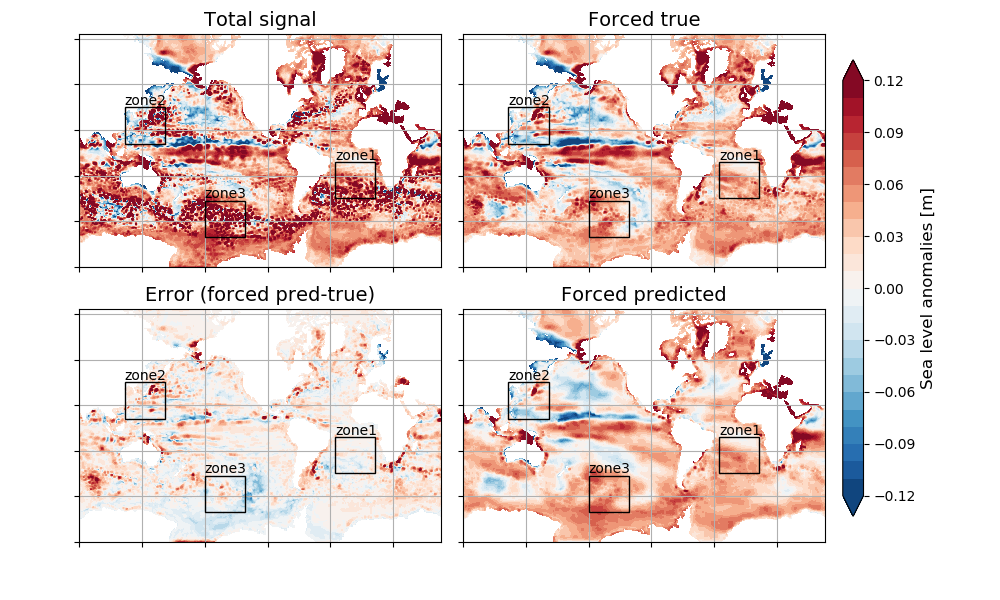

In [8]:
p = concat.plot.contourf(col='component', col_wrap=2, cmap='RdBu_r', figsize=(10,6),
                         levels=np.arange(-0.12,0.13,0.01), zorder=-20,
                         cbar_kwargs={'shrink': 0.9, 'pad': 0.02}
                        )

p.cbar.set_label('Sea level anomalies [m]', size=12)

titles = ['Total signal', 'Forced true', 'Error (forced pred-true)', 'Forced predicted']
for i, ax in enumerate(p.axes.flat):
    ax.set_title(titles[i], size=14)
    ax.set_rasterization_zorder(-10)
    ax.grid()
    ax.set_xticks(np.arange(0,1500,250))
    ax.get_xaxis().set_ticklabels([])
    ax.set_xlabel('')
    ax.get_yaxis().set_ticklabels([])
    ax.set_ylabel('')

    # add rectangles for training zone
    for z in ['zone1', 'zone2', 'zone3']:
        x_min, x_max, y_min, y_max = u.get_zone(z)
        rect = Rectangle(
            (x_min,y_min), x_max-x_min, y_max-y_min, linewidth=1, edgecolor='black', facecolor='none', zorder=10
        )
        ax.add_patch(rect)
        ax.annotate(z, xy=(x_min, y_max+10)) 

plt.savefig('img/pred.pdf', dpi=300)
plt.savefig('img/pred.png', dpi=300)

plt.show()